[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [5]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


In [6]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="openai/gpt-oss-120b",
               api_key=os.getenv("GROQ_API_KEY")
)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

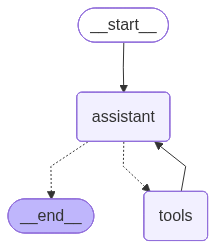

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (fc_2009b4ac-ef3f-40bc-9fcd-483ee8786802)
 Call ID: fc_2009b4ac-ef3f-40bc-9fcd-483ee8786802
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_a016df80-9494-4f39-be7f-a453b2bf1916)
 Call ID: fc_a016df80-9494-4f39-be7f-a453b2bf1916
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (fc_f8102808-4c4a-4b88-9448-2847ffc676c0)
 Call ID: fc_f8102808-4c4a-4b88-9448-2847ffc676c0
  Args:
    a: 14
    b: 5
==

## LangSmith

We can look at traces in LangSmith.

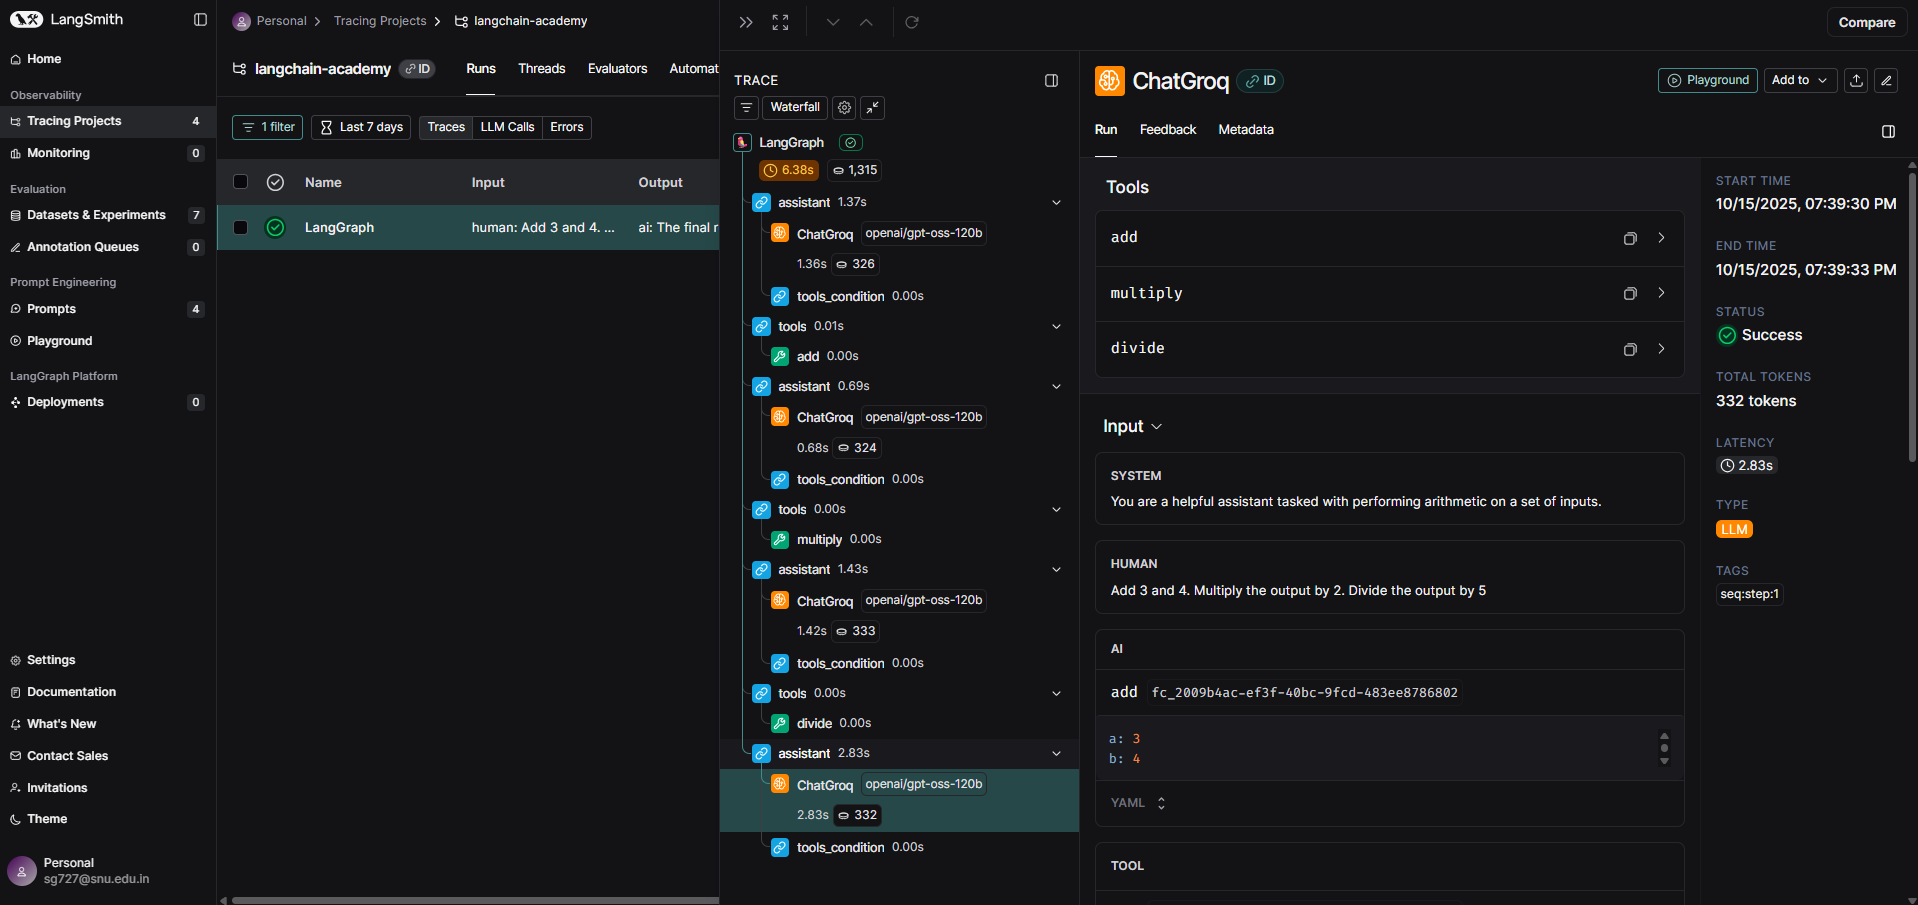

# MY EXAMPLES:

Here is a new example demonstrating the same agentic LLM pattern with different tools.

First, let's define a new set of tools.

In [11]:
# Define new tools for string manipulation
def reverse_string(text: str) -> str:
    """Reverses the input string."""
    return text[::-1]

def count_characters(text: str) -> int:
    """Counts the number of characters in the input string."""
    return len(text)

def to_uppercase(text: str) -> str:
    """Converts the input string to uppercase."""
    return text.upper()

new_tools = [reverse_string, count_characters, to_uppercase]

# Bind the new tools to the language model
llm_with_new_tools = llm.bind_tools(new_tools, parallel_tool_calls=False)

Now, let's define the assistant node for our new graph.

In [12]:
# Node for the new assistant
def new_assistant(state: MessagesState):
   return {"messages": [llm_with_new_tools.invoke([sys_msg] + state["messages"])]}

Next, we build a new graph with the `new_assistant` and `tools` nodes, similar to the previous example.

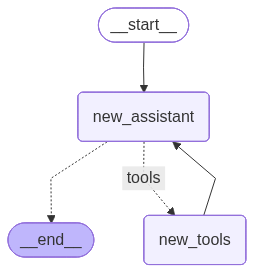

In [17]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# New Graph
new_builder = StateGraph(MessagesState)

# Define nodes using the new assistant and the existing ToolNode with new_tools
new_builder.add_node("new_assistant", new_assistant)
new_builder.add_node("new_tools", ToolNode(new_tools))

# Define edges
new_builder.add_edge(START, "new_assistant")
new_builder.add_conditional_edges(
    "new_assistant",
    # If the latest message (result) from assistant is a tool call -> routes to new_tools
    # If the latest message (result) from assistant is a not a tool call -> routes to END
    tools_condition,
    {"tools": "new_tools", "__end__": END} # Map the expected "tools" target to "new_tools" and "__end__" to END
)
new_builder.add_edge("new_tools", "new_assistant")
new_react_graph = new_builder.compile()

# Show the new graph structure
display(Image(new_react_graph.get_graph(xray=True).draw_mermaid_png()))

Finally, let's invoke the new graph with a message that utilizes the new tools.

In [18]:
new_messages = [HumanMessage(content="Reverse the string 'hello'. Then convert the output to uppercase. Then count the characters in the output.")]
new_messages = new_react_graph.invoke({"messages": new_messages})

# Print the messages to see the execution flow
for m in new_messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Reverse the string 'hello'. Then convert the output to uppercase. Then count the characters in the output.
================================== Ai Message ==================================
Tool Calls:
  reverse_string (fc_01eac3d7-d287-423a-87c4-4e981db021bd)
 Call ID: fc_01eac3d7-d287-423a-87c4-4e981db021bd
  Args:
    text: hello
================================= Tool Message =================================
Name: reverse_string

olleh
================================== Ai Message ==================================
Tool Calls:
  to_uppercase (fc_2f7a3666-d59d-4771-bb9a-cf4f45ec5415)
 Call ID: fc_2f7a3666-d59d-4771-bb9a-cf4f45ec5415
  Args:
    text: olleh
================================= Tool Message =================================
Name: to_uppercase

OLLEH
================================== Ai Message ==================================
Tool Calls:
  count_characters (fc_21af5de9-f405-4b49-80b8-fa730

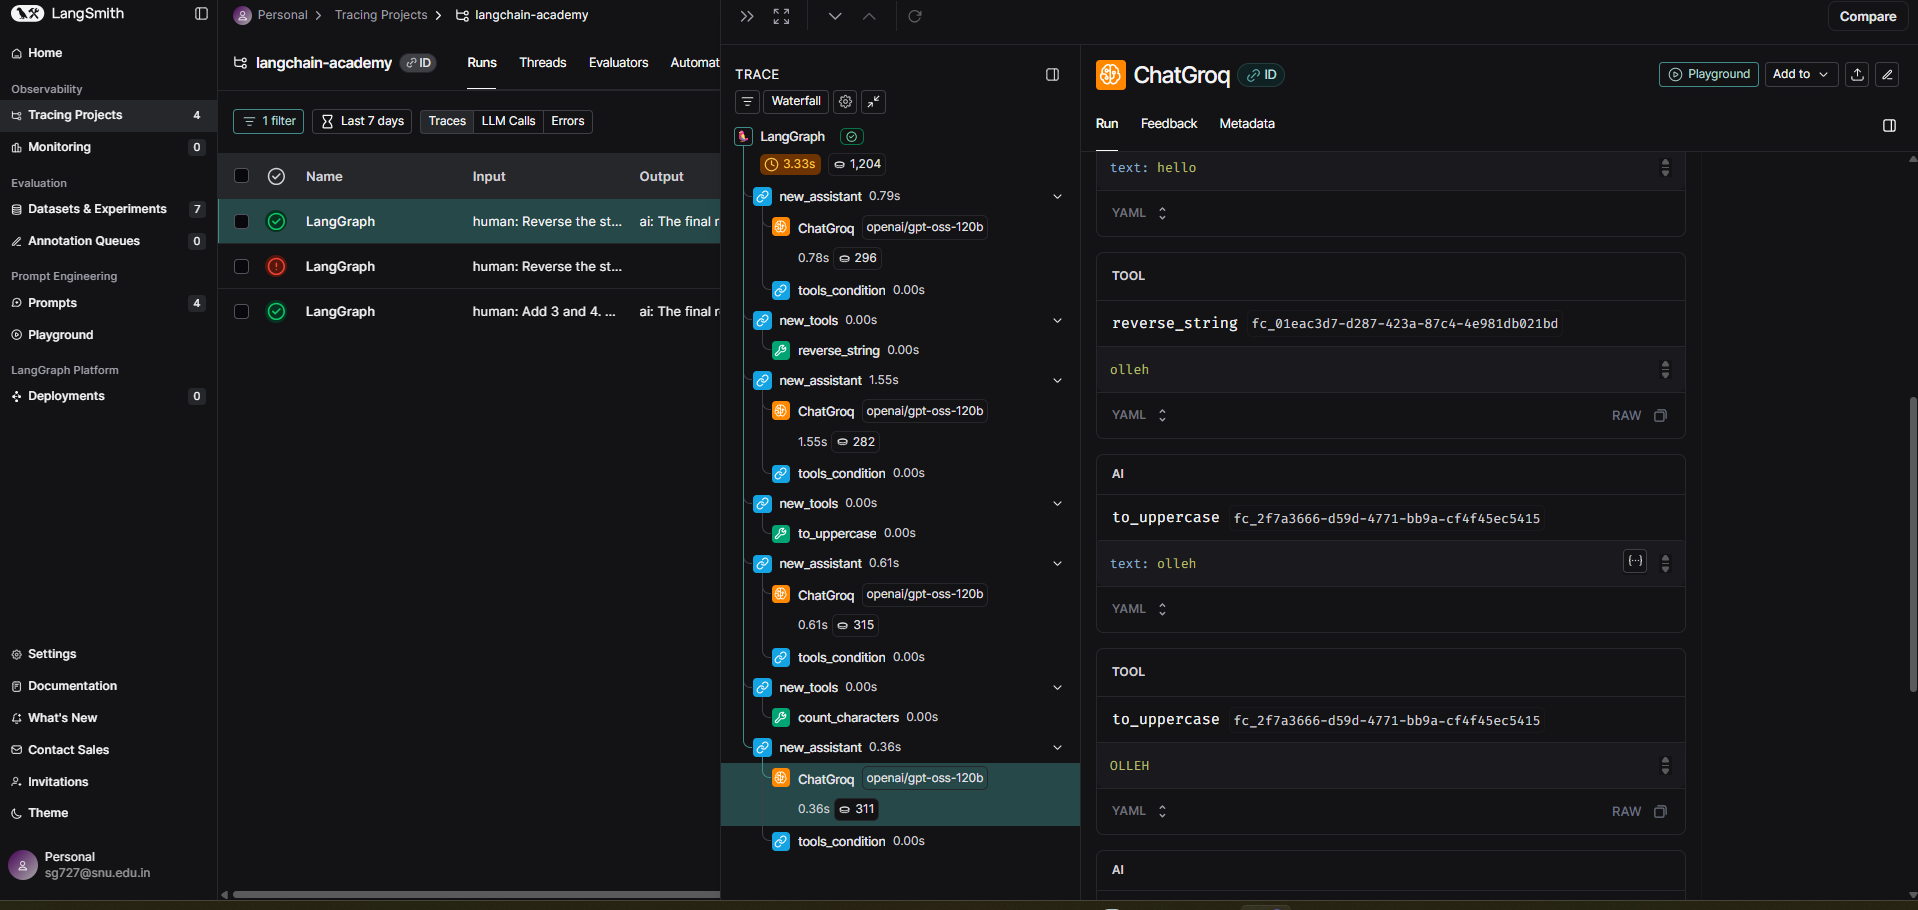